Processing audio files...
Training Transformer-based Autoencoder...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 4.9984
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4749
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0002
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5699
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.1828
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8365
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5241
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2434
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9917
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7662
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5642
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3837
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2219
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0775
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9488
Epoch 16/50
18

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Threshold for anomalies (95th percentile): 0.0071
Number of Clusters: 3, Silhouette Score: 0.2444
Number of Clusters: 4, Silhouette Score: 0.3001
Number of Clusters: 5, Silhouette Score: 0.3212
Number of Clusters: 6, Silhouette Score: 0.3357


<Figure size 800x600 with 0 Axes>

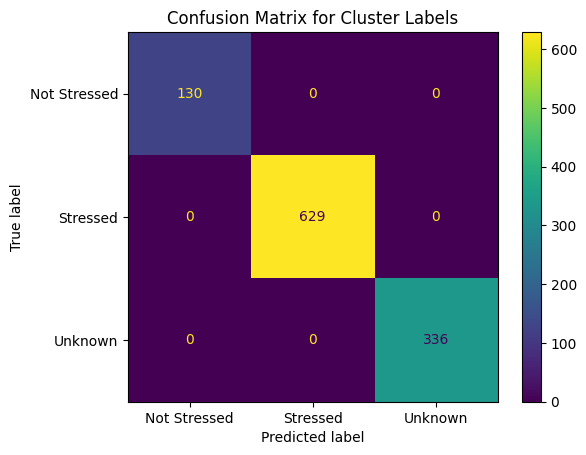

Results saved to /content/drive/MyDrive/Colab Notebooks/piping_database/bee_stress_analysis_with_errors.csv
Final Silhouette Score: 0.3357
Final Davies-Bouldin Index: 1.1038


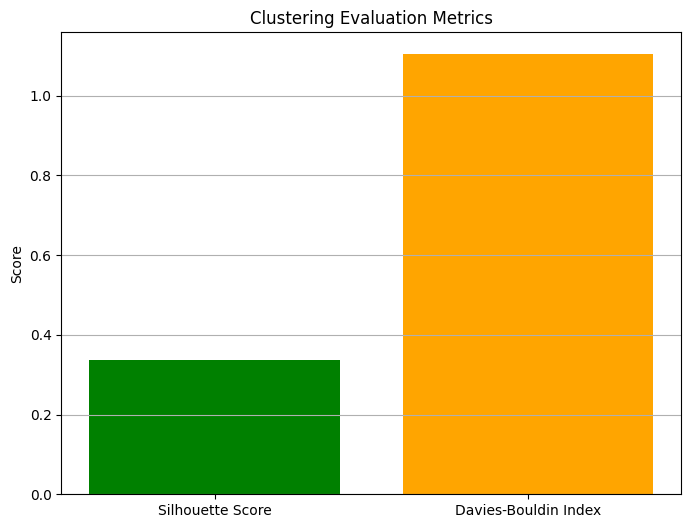

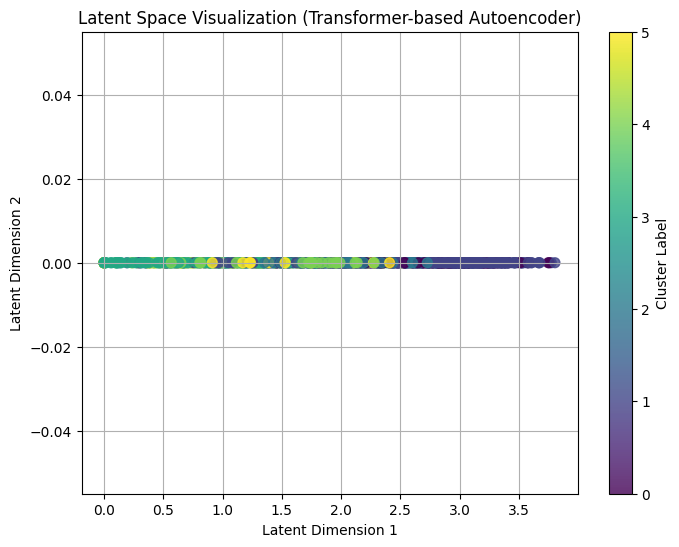

In [ ]:
import os
import glob
import numpy as np
import librosa
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Label Mapping
label_mapping = {
    0: ("Normal", "Not Stressed"),
    1: ("MissingQueenBee", "Stressed"),
    2: ("Swarming", "Stressed"),
    3: ("Hyper", "Stressed")
}

# Function to extract audio features
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Welch PSD Features
        freqs, psd = welch(y, fs=sr, nperseg=1024)
        band_definitions = [
            (300, 500),  # Tooting
            (300, 350),  # Quacking
            (300, 3600), # Hissing
            (100, 2000), # Piping
            (200, 350)   # Recruit
        ]
        psd_band_energy = [np.sum(psd[(freqs >= band[0]) & (freqs <= band[1])]) for band in band_definitions]

        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85).mean()

        # Combine features
        return np.hstack([mfcc_mean, *psd_band_energy, spectral_centroid, spectral_bandwidth, spectral_rolloff])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Process audio files
def process_audio_files(audio_dir):
    features = []
    file_names = []
    for file_path in glob.glob(f"{audio_dir}/**/*.*", recursive=True):
        if file_path.lower().endswith(('.wav', '.mp3')):
            #print(f"Processing {file_path}...")
            feature_vector = extract_audio_features(file_path)
            if feature_vector is not None:
                features.append(feature_vector)
                file_names.append(os.path.basename(file_path))
    return np.array(features), file_names
############################################################################################################
# Transformer Encoder Block


def transformer_encoder_block(inputs, num_heads, ff_dim, dropout_rate=0.2):
    # Multi-Head Attention with Dropout
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)  # Add Dropout
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)  # Residual connection

    # Feedforward Network with L2 Regularization and Dropout
    ffn_output = Dense(ff_dim, activation="relu", kernel_regularizer=l2(0.02))(attention_output)
    ffn_output = Dense(inputs.shape[-1], kernel_regularizer=l2(0.02))(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)  # Add Dropout
    return LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)  # Residual connection



# Build Transformer-based Autoencoder
def build_transformer_autoencoder(input_dim, encoding_dim, num_heads=4, ff_dim=64, dropout_rate=0.2):
    # Input Layer
    inputs = Input(shape=(input_dim,))
    x = Dense(encoding_dim, activation='relu')(inputs)  # Compress input features
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)  # Expand dimensions

    # Transformer Encoder Blocks with Dropout and Regularization
    for _ in range(3):  # Stacking 3 Transformer blocks
        x = transformer_encoder_block(x, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)

    x = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=1))(x)  # Squeeze dimensions back
    encoded = Dense(encoding_dim, activation='relu')(x)  # Latent representation

    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # Compile Autoencoder
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return autoencoder, encoder
######################################################################################################
# Visualize Latent Space
def visualize_latent_space(latent_features, labels, method_name="Transformer-based Autoencoder"):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_features[:, 0], latent_features[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f"Latent Space Visualization ({method_name})")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()
#
def feature_importance_Graph(latent_features):
    feature_importance = np.mean(np.abs(latent_features), axis=0)

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(feature_importance)), feature_importance, color='purple')
    plt.xlabel("Latent Feature Index")
    plt.ylabel("Average Contribution")
    plt.title("Feature Importance in Latent Space")
    plt.grid(True)
    plt.show()
# Add a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='viridis', values_format='d')
    plt.title(title)
    plt.show()
# Main Workflow
def main():
    audio_dir = "/content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/"
    print("Processing audio files...")
    features, file_names = process_audio_files(audio_dir)

    if features.size > 0:
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)

        input_dim = features_scaled.shape[1]
        encoding_dim = 32
        autoencoder, encoder = build_transformer_autoencoder(input_dim, encoding_dim)

        print("Training Transformer-based Autoencoder...")
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=64, shuffle=True, verbose=1, callbacks=[early_stopping])

        latent_features = encoder.predict(features_scaled)
        reconstruction = autoencoder.predict(features_scaled)

        # Calculate Reconstruction Error
        reconstruction_error = np.mean(np.square(features_scaled - reconstruction), axis=1)

        # Threshold Setting: Calculate the 95th percentile
        threshold = np.percentile(reconstruction_error, 95)
        print(f"Threshold for anomalies (95th percentile): {threshold:.4f}")

        # Classify samples based on reconstruction error
        anomaly_labels = ['Anomalous' if error > threshold else 'Normal' for error in reconstruction_error]

        # Choose the optimal number of clusters based on silhouette score
        optimal_n_clusters = None
        best_silhouette = -1
        for n_clusters in range(3, 7):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(latent_features)
            silhouette_avg = silhouette_score(latent_features, cluster_labels)
            print(f"Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                optimal_n_clusters = n_clusters

        # Final clustering with the best number of clusters
        kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(latent_features)

        # Dynamically handle stress state mapping
        cluster_labels_mapped = []
        for label in cluster_labels:
            if label in label_mapping:
                stress_label = label_mapping[label][1]  # "Not Stressed" or "Stressed"
            else:
                stress_label = "Unknown"  # Fallback for unmapped clusters
            cluster_labels_mapped.append(stress_label)

        # Assuming true labels are available for evaluation
        # Simulate or use actual labels for true_stress_labels
        true_stress_labels = [label_mapping[label][1] if label in label_mapping else "Unknown" for label in cluster_labels]

        # Plot the confusion matrix
        plot_confusion_matrix(true_stress_labels, cluster_labels_mapped, labels=["Not Stressed", "Stressed", "Unknown"], title="Confusion Matrix for Cluster Labels")

        # Create the results DataFrame
        results_df = pd.DataFrame({
            'File Name': file_names,
            'Cluster': cluster_labels,
            'Reconstruction Error': reconstruction_error,
            'Stress State': cluster_labels_mapped,
            'Anomaly Label': anomaly_labels
        })

        # Save results to CSV
        output_dir = "/content/drive/MyDrive/Colab Notebooks/piping_database"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        output_csv = os.path.join(output_dir, "bee_stress_analysis_with_errors.csv")
        results_df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")

        # Visualize clustering evaluation metrics
        silhouette_avg = silhouette_score(latent_features, cluster_labels)
        davies_bouldin_avg = davies_bouldin_score(latent_features, cluster_labels)
        print(f"Final Silhouette Score: {silhouette_avg:.4f}")
        print(f"Final Davies-Bouldin Index: {davies_bouldin_avg:.4f}")

        metrics = {
            'Silhouette Score': silhouette_avg,
            'Davies-Bouldin Index': davies_bouldin_avg
        }

        plt.figure(figsize=(8, 6))
        plt.bar(metrics.keys(), metrics.values(), color=['green', 'orange'])
        plt.ylabel("Score")
        plt.title("Clustering Evaluation Metrics")
        plt.grid(axis='y')
        plt.show()

        # Latent Space Visualization
        visualize_latent_space(latent_features, cluster_labels)
    else:
        print("No valid audio files processed.")

if __name__ == "__main__":
    main()
